In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

import read_data as rd
from metrics import cwcf, picpf, pinewf

In [2]:
ts_sm, ts_tr, ts_pe = rd.load_sp()

In [3]:
ts = ts_sm

In [4]:
ts_u_train, ts_u_test, ts_l_train, ts_l_test, ts_train, ts_test = rd.split_train_test(ts)

# Train

## 重新划分数据

In [5]:
d=range(1,3)
X1, y1 = rd.split_to_xy(ts_u_train, d)
X2, y2 = rd.split_to_xy(ts_l_train, d)
y3 = ts_train[len(d):]
X1.shape, y1.shape, X2.shape, y2.shape, y3.shape

((198, 2), (198,), (198, 2), (198,), (198,))

In [6]:
X = np.column_stack((X1,X2))
y = np.column_stack((y1,y2,y3))

In [7]:
X[:2,:2], X[:2,2:], X[:2]

(array([[88.5, 89.5],
        [86. , 88.5]]), array([[40. , 41. ],
        [37.5, 40. ]]), array([[88.5, 89.5, 40. , 41. ],
        [86. , 88.5, 37.5, 40. ]]))

In [8]:
y[:2,0], y[:2]

(array([86., 53.]), array([[86. , 37.5, 75. ],
        [53. ,  4.5,  9. ]]))

In [9]:
def split_to_Xy(ts, ts_u, ts_l, d=range(1,3)):
    X1, y1 = rd.split_to_xy(ts_u, d)
    X2, y2 = rd.split_to_xy(ts_l, d)
    y3 = ts[len(d):]
    X = np.column_stack((X1,X2))
    y = np.column_stack((y1,y2,y3))
    return X, y

## 训练模型

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
class PISvm(BaseEstimator, RegressorMixin):
    def __init__(self, gamma_u=0.001, C_u=10, gamma_l=0.001, C_l=10, mu=0.6, eta=10):
        self.gamma_u = gamma_u
        self.C_u = C_u
        self.gamma_l = gamma_l
        self.C_l = C_l
        self.mu = mu
        self.eta = eta
    
    def fit(self, X, y=None):
        X_u, y_u = X[:,:2], y[:,0]
        X_l, y_l = X[:,2:], y[:,1]
        self.svm_u = SVR(gamma=self.gamma_u, C=self.C_u)
        self.svm_l = SVR(gamma=self.gamma_l, C=self.C_l)
        self.svm_u.fit(X_u, y_u)
        self.svm_l.fit(X_l, y_l)
        return self

    def predict(self, X):
        X_u, X_l = X[:,:2], X[:,2:]
        pu = self.svm_u.predict(X_u)
        pl = self.svm_l.predict(X_l)
        p = np.column_stack((pu,pl))
        return p
    
    def score(self, X, y):
        p = self.predict(X)
        t = y[:,2]
        pu, pl = p[:,0], p[:,1]
        picp = picpf(t, pu, pl)
        pinew = pinewf(pu, pl)
        cwc = cwcf(picp, pinew, self.mu, self.eta)
        self.result = (cwc, picp, pinew)
        return cwc


In [11]:
pisvm = PISvm()
pisvm.fit(X, y)

PISvm(C_l=10, C_u=10, eta=10, gamma_l=0.001, gamma_u=0.001, mu=0.6)

In [12]:
X_test, y_test = split_to_Xy(ts_test, ts_u_test, ts_l_test)

In [13]:
X_test.shape, y_test.shape

((85, 4), (85, 3))

In [14]:
p = pisvm.predict(X_test)

In [15]:
pu, pl = p[:,0], p[:,1]

In [16]:
len(pu), len(pl)

(85, 85)

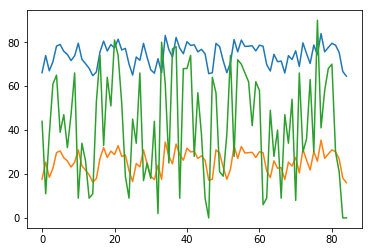

In [17]:
plt.plot(pu)
plt.plot(pl)
plt.plot(y_test[:,2])

In [18]:
pisvm.score(X_test, y_test)

0.7141630074498386

## 参数优化

In [23]:
tscv = TimeSeriesSplit(n_splits=3)

### GridSearchCV

In [77]:
pisvm = PISvm()
param_grid = {'gamma_u': np.arange(0.001,1.0,0.1), 'C_u': np.arange(10,30,1),
             'gamma_l': np.arange(0.001,1.0,0.1), 'C_l': np.arange(10,30,1),}
g_search = GridSearchCV(pisvm, param_grid=param_grid, cv=tscv)
g_search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise-deprecating',
       estimator=PISvm(C_l=10, C_u=10, eta=10, gamma_l=0.001, gamma_u=0.001, mu=0.6),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma_u': array([0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801,
       0.901]), 'C_u': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29]), 'gamma_l': array([0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801,
       0.901]), 'C_l': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
best_pisvm = g_search.best_estimator_

In [67]:
g_search.best_score_

2.2199381410211263

In [68]:
g_search.best_params_

{'C_l': 1.0, 'C_u': 100.0, 'gamma_l': 0.1, 'gamma_u': 100.0}

In [69]:
best_pisvm.fit(X, y)

PISvm(C_l=1.0, C_u=100.0, eta=10, gamma_l=0.1, gamma_u=100.0, mu=0.6)

In [71]:
p = best_pisvm.predict(X_test)

In [72]:
pu, pl = p[:,0], p[:,1]

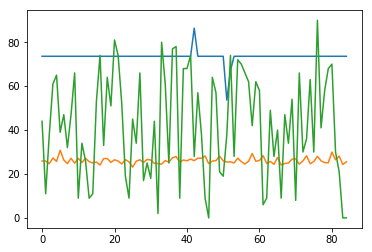

In [73]:
plt.plot(pu)
plt.plot(pl)
plt.plot(y_test[:,2])

In [75]:
best_pisvm.score(X_test, y_test)

0.7484336708298558

In [40]:
def mean_score(best_pisvm):
    cwc_l = np.array([get_score(best_pisvm, ts) for ts in rd.load_sp()])
    print(cwc_l)
    return cwc_l.mean()
    
def get_score(best_pisvm, ts):
    ts_u_train, ts_u_test, ts_l_train, ts_l_test, ts_train, ts_test = rd.split_train_test(ts)
    X_train, y_train = split_to_Xy(ts_train, ts_u_train, ts_l_train)
    X_test, y_test = split_to_Xy(ts_test, ts_u_test, ts_l_test)
    best_pisvm.fit(X_train, y_train)
    return best_pisvm.score(X_test, y_test)

In [76]:
mean_score(best_pisvm)

1.1474590893433405

### RandomizedSearchCV

In [58]:
pisvm = PISvm()
param_dist = {'gamma_u': np.arange(0.001,1.0,0.01), 'C_u': np.arange(10,30,1),
             'gamma_l': np.arange(0.001,1.0,0.01), 'C_l': np.arange(10,30,1),}
r_search = RandomizedSearchCV(pisvm, param_dist, cv=tscv, n_iter=1000)
r_search.fit(X, y)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise-deprecating',
          estimator=PISvm(C_l=10, C_u=10, eta=10, gamma_l=0.001, gamma_u=0.001, mu=0.6),
          fit_params=None, iid='warn', n_iter=1000, n_jobs=None,
          param_distributions={'gamma_u': array([0.001, 0.011, ..., 0.981, 0.991]), 'C_u': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29]), 'gamma_l': array([0.001, 0.011, ..., 0.981, 0.991]), 'C_l': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [ ]:
rbest_pisvm = r_search.best_estimator_

In [60]:
r_search.best_score_

2.295155652227096

In [61]:
r_search.best_params_

{'gamma_u': 0.9209999999999998,
 'gamma_l': 0.030999999999999996,
 'C_u': 22,
 'C_l': 10}

In [ ]:
mean_score(rbest_pisvm)